Let's start by creating a mapping of gene oncology (GO) term IDS to their label indices for each of the three subgraphs of the gene ontology.

In [9]:
from itertools import islice

obo_file_path = "./dataset/train/go-basic.obo"

bp_terms, cc_terms, mf_terms = [], [], []

with open(obo_file_path, 'r') as file:
    data = file.read().split("[Term]")

for term_data in data[1:]:  # Skip the first element as it is before the first [Term].
    lines = term_data.strip().splitlines()

    term_id = None
    namespace = None

    for line in lines:
        if line.startswith("id:"):
            term_id = line.split("id:")[1].strip()
        elif line.startswith("namespace:"):
            namespace = line.split("namespace:")[1].strip()

        if term_id and namespace:
            match namespace:
                case "biological_process":
                    bp_terms.append(term_id)
                case "cellular_component":
                    cc_terms.append(term_id)
                case "molecular_function":
                    mf_terms.append(term_id)
                case _:
                    # Ignore other namespaces
                    pass
            break

# Print the first 10 terms.
for term_mapping in [bp_terms, cc_terms, mf_terms]:
    for label_index, term_id in enumerate(term_mapping[:10]):
        print(f"{term_id} => {label_index}")

    print("\n")


GO:0000001 => 0
GO:0000002 => 1
GO:0000003 => 2
GO:0000011 => 3
GO:0000012 => 4
GO:0000017 => 5
GO:0000018 => 6
GO:0000019 => 7
GO:0000020 => 8
GO:0000022 => 9


GO:0000015 => 0
GO:0000108 => 1
GO:0000109 => 2
GO:0000110 => 3
GO:0000111 => 4
GO:0000112 => 5
GO:0000113 => 6
GO:0000118 => 7
GO:0000120 => 8
GO:0000123 => 9


GO:0000005 => 0
GO:0000006 => 1
GO:0000007 => 2
GO:0000008 => 3
GO:0000009 => 4
GO:0000010 => 5
GO:0000014 => 6
GO:0000016 => 7
GO:0000026 => 8
GO:0000030 => 9




Next, let's count the number of unique GO terms so we know how many classes we need to represent in the output layer of the Transformer.

In [10]:
num_bp_classes = len(bp_terms)
num_cc_classes = len(cc_terms)
num_mf_classes = len(mf_terms)

total_num_classes = num_bp_classes + num_cc_classes + num_mf_classes

print(f"Number of biological process classes: {num_bp_classes:,}")
print(f"Number of cellular component classes: {num_cc_classes:,}")
print(f"Number of molecular function classes: {num_mf_classes:,}")

print("\n")

print(f"Total number of classes: {total_num_classes:,}")

Number of biological process classes: 30,510
Number of cellular component classes: 4,469
Number of molecular function classes: 12,438


Total number of classes: 47,417


Now let's map the sequence IDs to their GO term label indices. We'll also count the GO terms so we can plot them later.

In [22]:
import pandas as pd

from collections import defaultdict, Counter

terms_path = "./dataset/train/train_terms.tsv"

bp_counter = Counter()
cc_counter = Counter()
mf_counter = Counter()

# Convert to dict for O(1) label index lookup.
bp_terms = {term: index for index, term in enumerate(bp_terms)}
cc_terms = {term: index for index, term in enumerate(cc_terms)}
mf_terms = {term: index for index, term in enumerate(mf_terms)}

bp_sequence_to_label_indices = defaultdict(list)
cc_sequence_to_label_indices = defaultdict(list)
mf_sequence_to_label_indices = defaultdict(list)

df = pd.read_csv(terms_path, sep='\t')

for _, row in df.iterrows():
    sequence_id = row["EntryID"]
    term_id = row["term"]

    match row["aspect"]:
        case "BPO":
            label_index = bp_terms[term_id]
            bp_sequence_to_label_indices[sequence_id].append(label_index)
            bp_counter[term_id] += 1
        case "CCO":
            label_index = cc_terms[term_id]
            cc_sequence_to_label_indices[sequence_id].append(label_index)
            cc_counter[term_id] += 1
        case "MFO":
            label_index = mf_terms[term_id]
            mf_sequence_to_label_indices[sequence_id].append(label_index)
            mf_counter[term_id] += 1
        case _:
            # Ignore other aspects
            continue

bp_first_10 = dict(islice(bp_sequence_to_label_indices.items(), 10))
cc_first_10 = dict(islice(cc_sequence_to_label_indices.items(), 10))
mf_first_10 = dict(islice(mf_sequence_to_label_indices.items(), 10))

# Print the first 10 sequence to label index mappings.
for sequence_to_label_mapping in [bp_first_10, cc_first_10, mf_first_10]:
    for sequence_id, label_indices in sequence_to_label_mapping.items():
        print(f"{sequence_id} => {label_indices}")

    print("\n")

A0A009IHW8 => [3525, 9994, 20271, 12676, 2711, 24639, 12657, 24703, 3524, 24891, 24892, 3712, 2161, 12683, 14137, 6596, 14125, 16750, 12664, 6668, 6855, 2758, 6891, 24704, 2180, 14270, 4267, 2687, 2747, 9984, 20269, 19639, 6598, 24901, 20274, 14079, 3758, 20272, 2212, 3653, 12658, 2744, 6888]
A0A021WW32 => [15123, 15111, 7537, 18570, 3160, 2966, 22063, 11798, 14805, 3524, 26195, 3270, 4744, 15286, 14770, 6468, 7709, 119, 14771, 303, 7570, 14996, 22909, 2957, 14964, 4207, 5776, 8792, 16992, 4267, 5639, 19713, 2968, 4767, 7233, 2970, 14627, 2914, 31, 117, 7723, 8791, 4643, 14932, 18664, 15689, 19630]
A0A023FFD0 => [17038, 4262, 18570, 4787, 17036, 7646, 3524, 29398, 4644, 15541, 15399, 15286, 4785, 15397, 12607, 23519, 15290, 4260, 14860, 11436, 8530, 7640, 18572, 23535, 15539, 7806, 12263, 14810, 23534, 14806, 14862, 23518, 11435, 29399, 8531, 7808, 8521]
A0A023GPJ3 => [14392, 18571, 7640, 18570, 1424, 4787, 7646, 26616, 15501, 15504, 15506, 3524, 21242, 1423, 4945, 21064, 15286, 4785, 

Next thing we'll do is plot the top k GO terms for each subgraph using a bar chart.

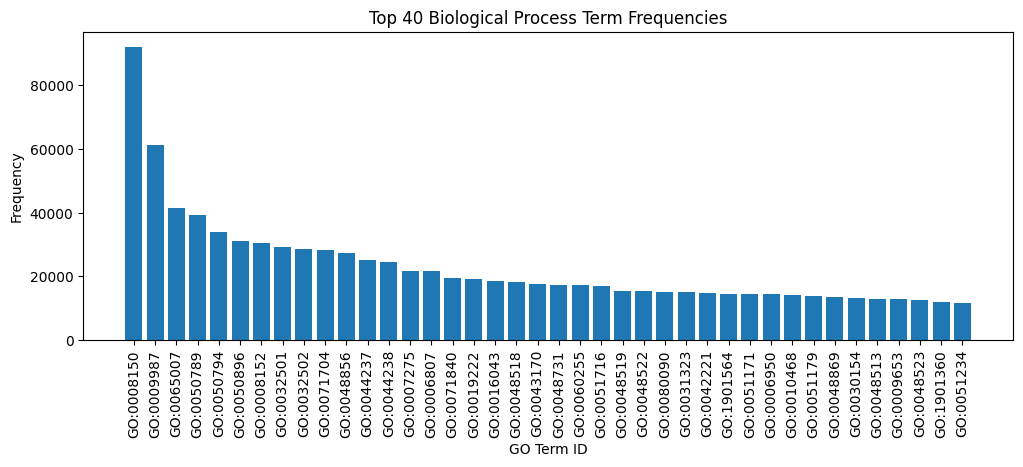

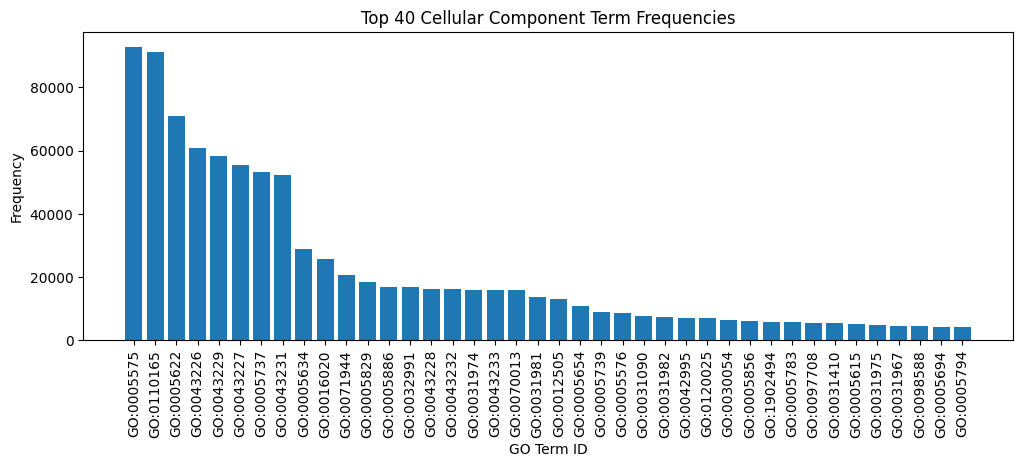

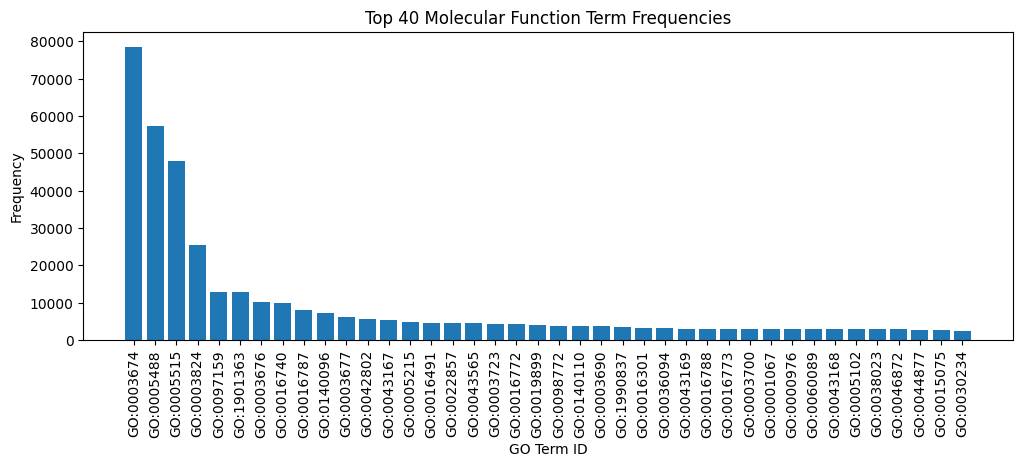

In [62]:
import matplotlib.pyplot as plt

top_k = 40

for name, counter in [
    ("Biological Process", bp_counter),
    ("Cellular Component", cc_counter),
    ("Molecular Function", mf_counter),
]:
    counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

    first_k = dict(islice(counter.items(), top_k))

    plt.figure(figsize=(12, 4)) 

    plt.bar(first_k.keys(), first_k.values())

    plt.xticks(rotation=90)
    plt.xlabel("GO Term ID")
    plt.ylabel("Frequency")
    plt.title(f"Top {top_k} {name} Term Frequencies")

    plt.show()

Let's read through the training samples and create a new JSONL dataset that contains the raw protein sequences and a list of their GO term label indices for each of the GO subgraphs. This will be the file that we read from when fine-tuning the model.

In [63]:
import json

from Bio import SeqIO

fasta_path = "./dataset/train/train_sequences.fasta"

mf_dataset_path = "./dataset/mf_dataset.jsonl"
bp_dataset_path = "./dataset/bp_dataset.jsonl"
cc_dataset_path = "./dataset/cc_dataset.jsonl"

for dataset_path, sequence_to_label_indices in [
    (mf_dataset_path, mf_sequence_to_label_indices),
    (bp_dataset_path, bp_sequence_to_label_indices),
    (cc_dataset_path, cc_sequence_to_label_indices),
]:
    with open(dataset_path, "w") as dataset_file:   
        with open(fasta_path, "r") as fasta_file:
            for record in SeqIO.parse(fasta_file, "fasta"):
                sequence_id = record.id
                sequence = str(record.seq)

                label_indices = sequence_to_label_indices[sequence_id]

                line = {
                    "sequence_id": sequence_id,
                    "sequence": sequence,
                    "label_indices": label_indices
                }

                dataset_file.write(json.dumps(line) + "\n")

            print(f"Dataset saved to {dataset_path}")



Dataset saved to ./dataset/mf_dataset.jsonl
Dataset saved to ./dataset/bp_dataset.jsonl
Dataset saved to ./dataset/cc_dataset.jsonl
